In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
cabbage_df = pd.read_excel("D:/humanda/WORKSPACE/projects_mook/data-files2/양배추_가격.xlsx", engine='openpyxl')

In [143]:
cabbage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5421 entries, 0 to 5420
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     5421 non-null   object 
 1   거래단위     5421 non-null   object 
 2   평균가격     5421 non-null   object 
 3   총거래물량    5421 non-null   float64
 4   총거래금액    5421 non-null   int64  
 5   도매시장     5421 non-null   object 
 6   도매법인     5421 non-null   object 
 7   품목       5421 non-null   object 
 8   품종       5421 non-null   object 
 9   산지-광역시도  5421 non-null   object 
 10  등급       5421 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 466.0+ KB


In [144]:
cabbage_df['도매시장'].unique()

array(['구리도매시장', '인천구월도매', '서울강서도매', '수원도매시장', '순천도매시장', '안양도매시장',
       '창원내서도매시장', '광주각화도매', '전주도매시장', '원주도매시장', '부산반여도매', '청주도매시장',
       '천안도매시장', '안산도매시장', '창원팔용도매시장', '춘천도매시장', '대전노은도매', '대구북부도매',
       '광주서부도매', '부산엄궁도매', '포항도매시장', '강릉도매시장', '울산도매시장', '인천삼산도매',
       '정읍도매시장', '대전오정도매', '서울가락도매', '진주도매시장', '충주도매시장', '구미도매시장'],
      dtype=object)

In [145]:
cabbage_df['산지-광역시도'].unique()

array(['충청남도', '강원도', '제주', '전라남도', '전남', '충남', '경상남도', '전북', '경상북도',
       '강원', '전라북도', '충북', '부산', '서울특별시', '-', '경남', '서울', '충청북도',
       '부산광역시', '광주', '경북', '경기도', '대전광역시', '경기', '광주광역시', '제주도', '대구광역시',
       '인천', '중국', '대구', '울산', '울산광역시', '대전'], dtype=object)

In [146]:
cabbage_df['평균가격'] = pd.to_numeric(cabbage_df['평균가격'], errors='coerce')
cabbage_df['총거래물량'] = pd.to_numeric(cabbage_df['총거래물량'], errors='coerce')


cabbage_df_cleaned = cabbage_df.dropna(subset=['평균가격', '총거래물량', '도매시장', '산지-광역시도'])




cabbage_df_cleaned['weighted_price'] = (
    cabbage_df_cleaned['평균가격'] * cabbage_df_cleaned['총거래물량']
)

cabbage_df_cleaned['산지-광역시도'] = cabbage_df_cleaned['산지-광역시도'].replace(region_sum)



weighted_avg_market = (
    cabbage_df_cleaned.groupby(['DATE', '도매시장']).apply(
        lambda g: g['weighted_price'].sum() / g['총거래물량'].sum()
    ).reset_index(name='가중평균가격')
)

weighted_avg_ragion = (
    cabbage_df_cleaned.groupby(['DATE', '산지-광역시도'])
    .apply(lambda g: g['weighted_price'].sum() / g['총거래물량'].sum())
    .reset_index(name='가중평균가격')
)

C:\Users\human\AppData\Local\Temp\ipykernel_10456\4174360441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabbage_df_cleaned['weighted_price'] = (
C:\Users\human\AppData\Local\Temp\ipykernel_10456\4174360441.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabbage_df_cleaned['산지-광역시도'] = cabbage_df_cleaned['산지-광역시도'].replace(region_sum)
C:\Users\human\AppData\Local\Temp\ipykernel_10456\4174360441.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is

In [147]:
weighted_avg_market['도매시장'].unique()

array(['강릉도매시장', '광주각화도매', '광주서부도매', '구리도매시장', '구미도매시장', '대구북부도매',
       '대전노은도매', '부산반여도매', '부산엄궁도매', '서울강서도매', '수원도매시장', '순천도매시장',
       '안산도매시장', '울산도매시장', '원주도매시장', '인천구월도매', '전주도매시장', '진주도매시장',
       '창원내서도매시장', '창원팔용도매시장', '천안도매시장', '춘천도매시장', '포항도매시장', '서울가락도매',
       '대전오정도매', '충주도매시장', '인천삼산도매', '청주도매시장', '안양도매시장', '정읍도매시장'],
      dtype=object)

<Figure size 1400x800 with 0 Axes>

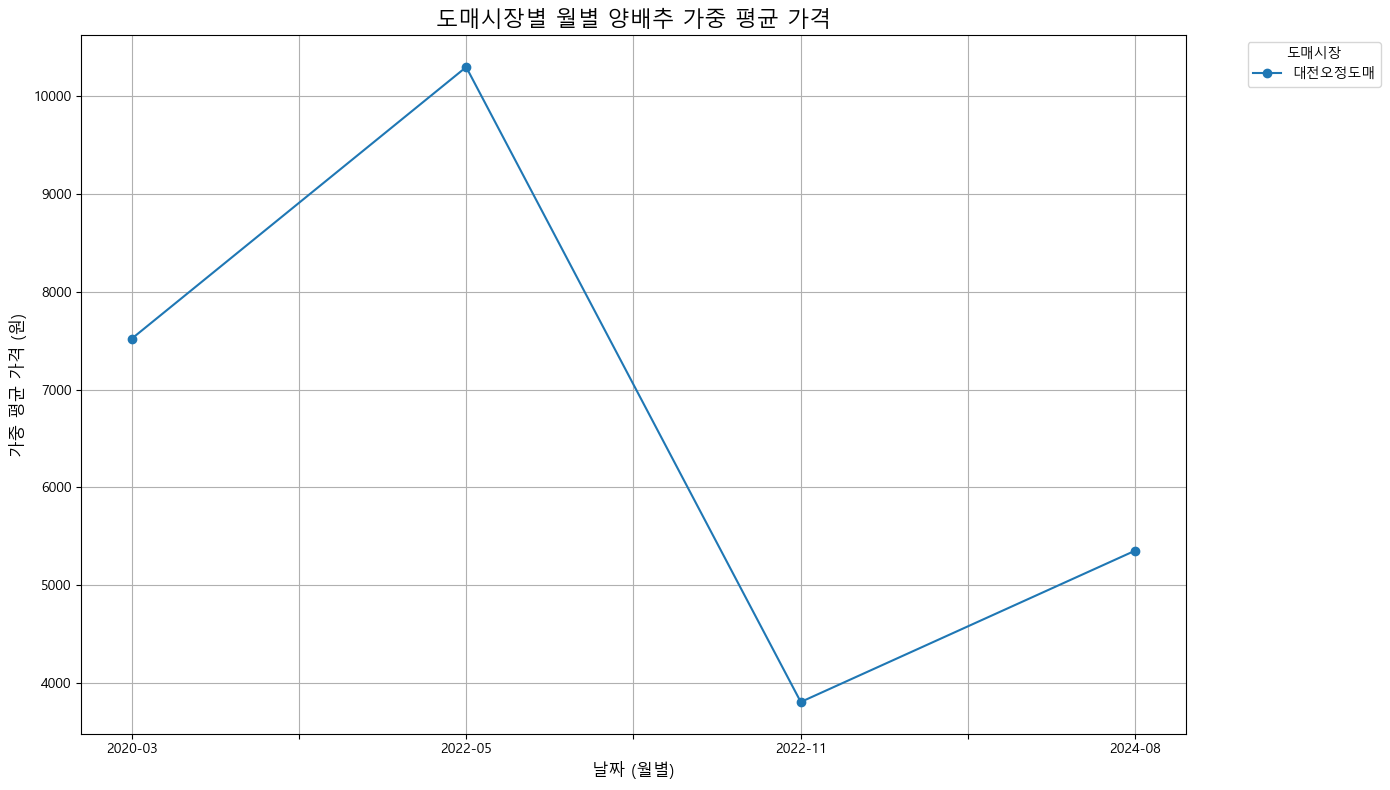

In [148]:
import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


cabbage_market_pivot = weighted_avg_market[weighted_avg_market['도매시장'] == '대전오정도매'].pivot(index='DATE', columns='도매시장', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_market_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('도매시장별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='도매시장', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

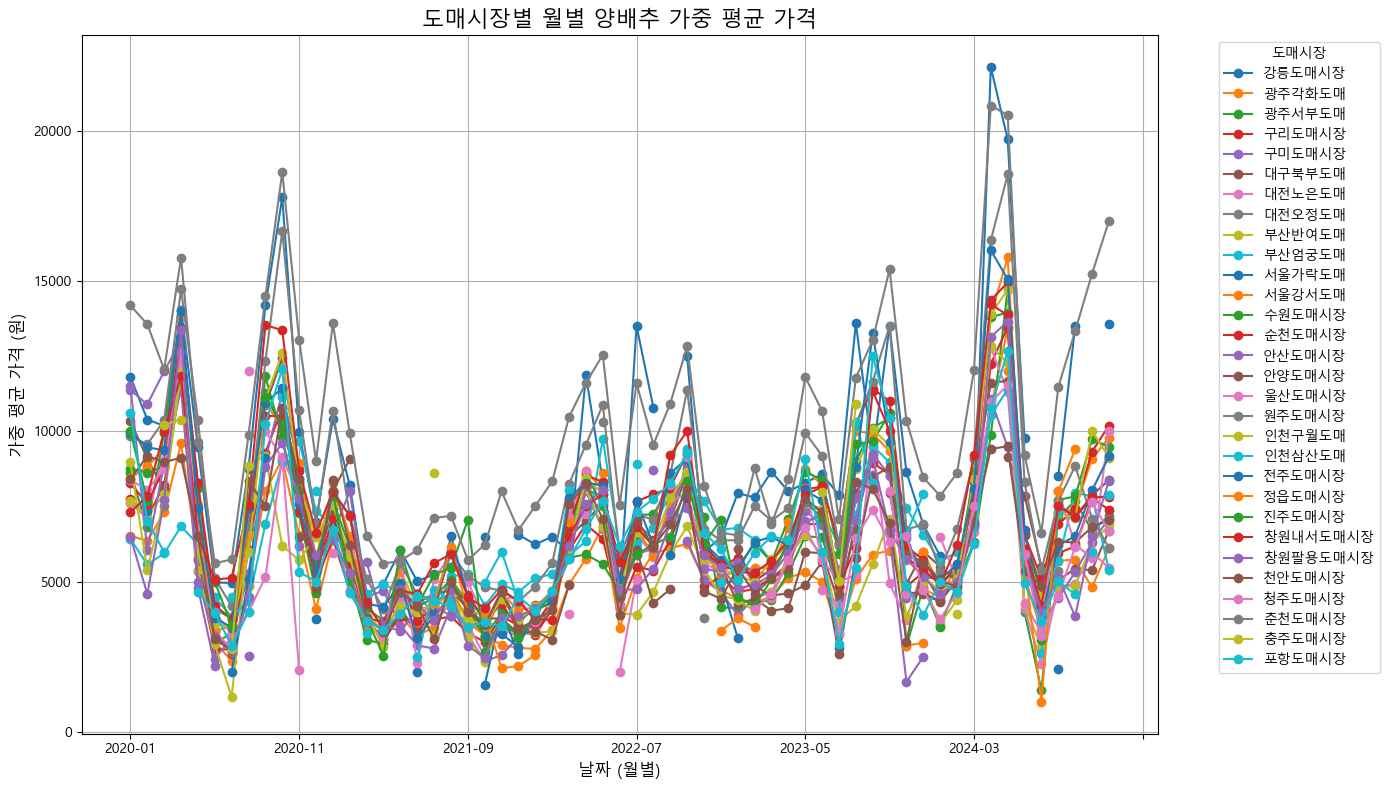

In [149]:
import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


cabbage_market_pivot = weighted_avg_market.pivot(index='DATE', columns='도매시장', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_market_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('도매시장별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='도매시장', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [150]:
cabbage_df['산지-광역시도'].unique()

array(['충청남도', '강원도', '제주', '전라남도', '전남', '충남', '경상남도', '전북', '경상북도',
       '강원', '전라북도', '충북', '부산', '서울특별시', '-', '경남', '서울', '충청북도',
       '부산광역시', '광주', '경북', '경기도', '대전광역시', '경기', '광주광역시', '제주도', '대구광역시',
       '인천', '중국', '대구', '울산', '울산광역시', '대전'], dtype=object)

In [151]:
region_sum = {
    '충남': '충청남도', 
    '강원': '강원도', 
    '제주':'제주도', 
    '전남' : '전라남도',
    '전북' : '전라북도', 
    '강원' : '강원도',
    '충북' : '충청북도',
    '부산' : '부산광역시',
    '경남' : '경상남도',
    '서울' : '서울특별시',
    '광주' : '광주광역시', 
    '경북' : '경상북도',
    '경기' : '경기도',
    '인천' : '인천광역시',
    '대구' : '대구광역시',
    '울산' : '울산광역시',
    '대전' : '대전광역시'
}

<Figure size 1400x800 with 0 Axes>

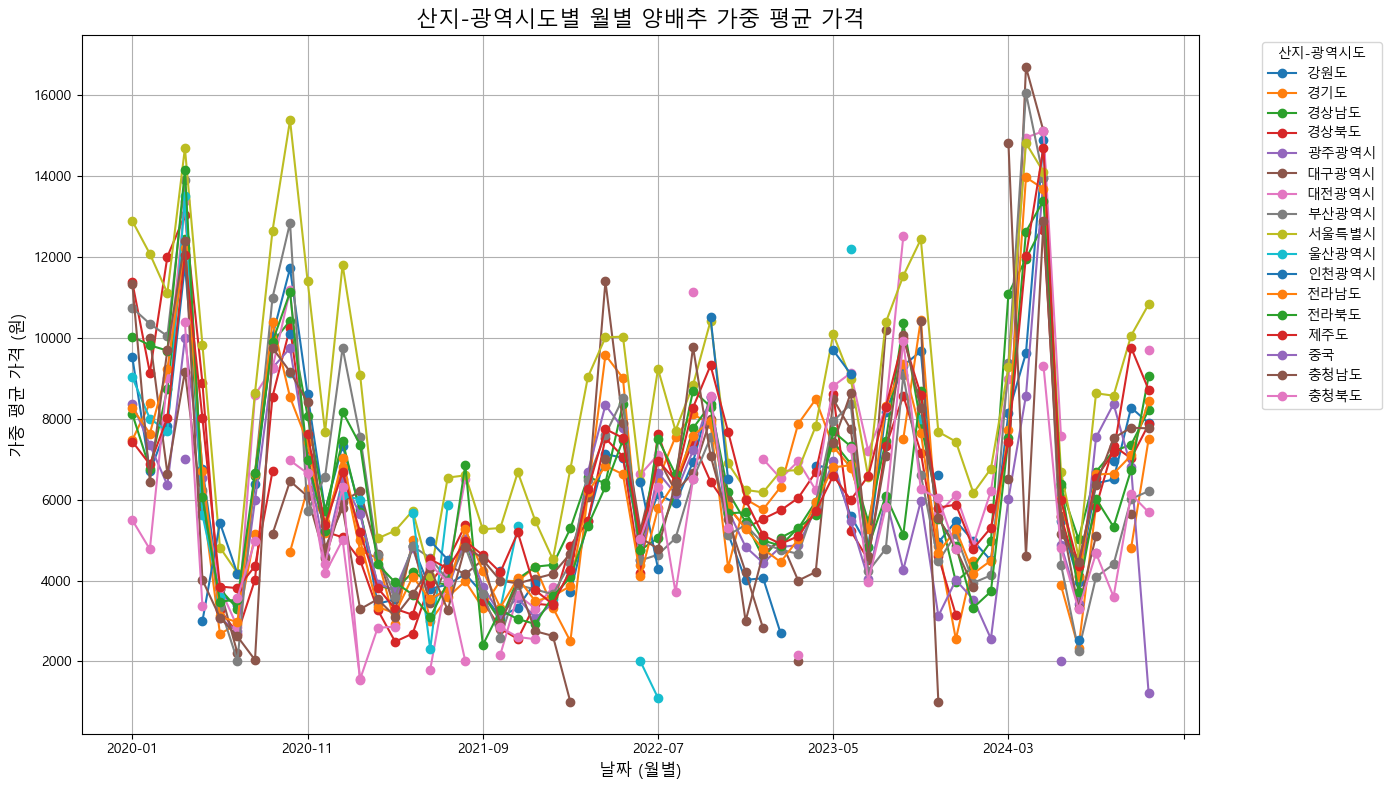

In [155]:
import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

weighted_avg_ragion = weighted_avg_ragion[weighted_avg_ragion['산지-광역시도'] != '-']

cabbage_ragion_pivot = weighted_avg_ragion.pivot(index='DATE', columns='산지-광역시도', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_ragion_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('산지-광역시도별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='산지-광역시도', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()